## 0. Setup 

In [ ]:
from pathlib import Path
import os, random, numpy as np

DATA_ROOT   = Path("/content/drive/MyDrive/data/brisc2025/classification_task")
OUT_DIR     = Path("outputs")
REPORTS_DIR = OUT_DIR / "reports"
MODELS_DIR  = OUT_DIR / "models"
for d in (OUT_DIR, REPORTS_DIR, MODELS_DIR):
    d.mkdir(parents=True, exist_ok=True)

IMG_SIZE     = 128
CLASS_NAMES  = ["glioma", "meningioma", "no_tumor", "pituitary"]
SEARCH_CV    = 5
N_JOBS       = -1
PCA_VAR      = 0.95
RANDOM_STATE = 42

os.environ["PYTHONHASHSEED"] = str(RANDOM_STATE)
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

STATE = {
    "X_train": None, "y_train": None,
    "X_test": None,  "y_test": None,
    "pipeline": None,
    "best_params": None,
}
print("Environment initialized.")

Environment initialized.


 ## 1. Imports

In [ ]:
import cv2, json, matplotlib.pyplot as plt, numpy as np, pandas as pd
from pathlib import Path
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, balanced_accuracy_score, f1_score
)

## 2. Data Preprocessing - IO

In [ ]:
from typing import Sequence, Tuple, List

def resize_letterbox(img: np.ndarray, target: int = IMG_SIZE) -> np.ndarray:
    if img.shape[0] == target and img.shape[1] == target:
        return img
    h, w = img.shape[:2]
    scale = target / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)
    interp = cv2.INTER_AREA if scale < 1.0 else cv2.INTER_CUBIC
    img_resized = cv2.resize(img, (new_w, new_h), interpolation=interp)
    pad_top = (target - new_h) // 2
    pad_bottom = target - new_h - pad_top
    pad_left = (target - new_w) // 2
    pad_right = target - new_w - pad_left
    return cv2.copyMakeBorder(
        img_resized, pad_top, pad_bottom, pad_left, pad_right,
        borderType=cv2.BORDER_CONSTANT, value=0
    )

def _class_to_idx(class_names: Sequence[str]) -> dict:
    return {name: i for i, name in enumerate(class_names)}

def list_images_split(
    data_root: Path | str = DATA_ROOT,
    split: str = "train",
    class_names: Sequence[str] = None,
    exts: Tuple[str, ...] = ("*.jpg", "*.jpeg", "*.png"),
) -> Tuple[List[Path], np.ndarray]:

    if class_names is None:
        class_names = CLASS_NAMES
    split_dir = Path(data_root) / split
    cls2idx = _class_to_idx(class_names)

    paths, labels = [], []
    for cls in class_names:
        cls_dir = split_dir / cls
        found = []
        for ext in exts:
            found.extend(cls_dir.glob(ext))
        for p in sorted(found):
            paths.append(p)
            labels.append(cls2idx[cls])

    return paths, np.asarray(labels, dtype=np.int64)

def load_image_gray(path: Path, img_size: int = IMG_SIZE) -> np.ndarray:
    im = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    im = resize_letterbox(im, img_size)
    return (im.astype(np.float32) / 255.0)

def load_batch(paths: Sequence[Path], img_size: int = IMG_SIZE) -> np.ndarray:
    return np.stack([load_image_gray(p, img_size) for p in paths], axis=0)

def load_data():
    paths_train, y_train = list_images_split(DATA_ROOT, "train")
    paths_test,  y_test  = list_images_split(DATA_ROOT, "test")
    
    X_train = load_batch(paths_train, IMG_SIZE)
    X_test  = load_batch(paths_test, IMG_SIZE)
    
    print("Data loaded.")
    print("Train shape:", X_train.shape, " | Train labels:", y_train.shape)
    print("Test shape: ", X_test.shape,  " | Test labels: ", y_test.shape)
    
    return X_train, X_test, y_train, y_test

 ## 3. Describe data

In [ ]:
def describe_data(y_train, y_test):
    train_counts = pd.Series(y_train).value_counts().sort_index()
    test_counts  = pd.Series(y_test).value_counts().sort_index()
    
    idx2cls = {i: n for i, n in enumerate(CLASS_NAMES)}
    
    train_counts.index = [idx2cls[i] for i in train_counts.index]
    test_counts.index  = [idx2cls[i] for i in test_counts.index]

    fig, ax = plt.subplots(1,2, figsize=(10,4))
    train_counts.plot(kind="bar", ax=ax[0], title="Train class counts")
    test_counts.plot(kind="bar", ax=ax[1], title="Test class counts")
    
    plt.tight_layout(); plt.show()

## 4. Pipeline: HOG -> PCA -> RF

In [ ]:
from skimage.feature import hog

HOG_PARAMS_DEFAULT = dict(
    orientations=9,
    pixels_per_cell=(8,8),
    cells_per_block=(2,2),
    block_norm="L2-Hys",
)

class HOGTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,
                 orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(2, 2),
                 block_norm="L2-Hys"):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=np.float32)
        
        f0 = hog(
            X[0],
            orientations=self.orientations,
            pixels_per_cell=self.pixels_per_cell,
            cells_per_block=self.cells_per_block,
            block_norm=self.block_norm,
            feature_vector=True
        ).astype(np.float32)

        feats = np.empty((len(X), f0.size), dtype=np.float32)
        feats[0] = f0
        for i in range(1, len(X)):
            feats[i] = hog(
                X[i],
                orientations=self.orientations,
                pixels_per_cell=self.pixels_per_cell,
                cells_per_block=self.cells_per_block,
                block_norm=self.block_norm,
                feature_vector=True
            ).astype(np.float32)
            
        return feats

class ShapeLogger(BaseEstimator, TransformerMixin):
    def __init__(self, name=""):
        self.name = name
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print(f"[LOG] {self.name} shape: {getattr(X, 'shape', None)}")
        return X

def build_pipeline(hog_params=None, pca_n_components=None, rf_params=None):
    hog_cfg = {**HOG_PARAMS_DEFAULT, **(hog_params or {})}

    if pca_n_components is not None:
        pca_nc = pca_n_components
    else:
        pca_nc = PCA_VAR  

    base_rf_cfg = {"random_state": RANDOM_STATE}
    if 'N_JOBS' in globals() and N_JOBS is not None:
        base_rf_cfg["n_jobs"] = N_JOBS
    rf_cfg = {**base_rf_cfg, **(rf_params or {})}

    return Pipeline([
        ("hog", HOGTransformer(**hog_cfg)),
        ("log1", ShapeLogger("After HOG")),
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=pca_nc, random_state=RANDOM_STATE)),
        ("log2", ShapeLogger("After PCA")),
        ("clf", RandomForestClassifier(**rf_cfg)),
    ])


## 5. Hyperparameters Optimization

In [ ]:
SPACE_JOINT = {
    # === HOG ===
    "hog__orientations": [9, 12, 18],
    "hog__pixels_per_cell": [(8,8), (12,12)],
    "hog__cells_per_block": [(2,2), (3,3)],

    # === PCA ===
    "pca__n_components": [0.90, 0.95, 128, 256],

    # === Random Forest ===
    "clf__n_estimators": [200, 400, 600, 800],
    "clf__max_depth": [None, 20, 30, 40],
    "clf__max_features": ["sqrt", "log2"],
    "clf__min_samples_split": [1, 2, 5],
    "clf__min_samples_leaf": [1, 2, 4],
}

def hpo(X_train, y_train):
    cv = StratifiedKFold(n_splits=SEARCH_CV, shuffle=True, random_state=RANDOM_STATE)
    est = build_pipeline()

    search = RandomizedSearchCV(
        estimator=est,
        param_distributions=SPACE_JOINT,
        n_iter=12,
        cv=cv,
        scoring="f1_macro",
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS,
        verbose=2
    )

    search.fit(X_train, y_train)

    print("=== Best Params ===")
    print(json.dumps(search.best_params_, indent=2))
    
    return search.best_estimator_, search.best_params_

## 6. Evaluation

In [ ]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)

    print("\n=== Metrics ===")
    print("Accuracy:          ", accuracy_score(y_test, y_pred))
    print("Balanced Accuracy: ", balanced_accuracy_score(y_test, y_pred))
    print("F1 Macro:          ", f1_score(y_test, y_pred, average="macro"))

    print("\n=== Classification Report ===")
    print(classification_report(y_test, y_pred, target_names=CLASS_NAMES, digits=2))

 
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, cmap=plt.cm.Blues)
    plt.colorbar(im, ax=ax)

    ax.set_xticks(range(len(CLASS_NAMES)))
    ax.set_yticks(range(len(CLASS_NAMES)))
    ax.set_xticklabels(CLASS_NAMES, rotation=45, ha="right")
    ax.set_yticklabels(CLASS_NAMES)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title("Confusion Matrix")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.tight_layout()
    plt.show()


## 8. Run

Data loaded.
Train shape: (5000, 128, 128) Train labels: (5000,)
Test shape:  (1000, 128, 128) Test labels:  (1000,)


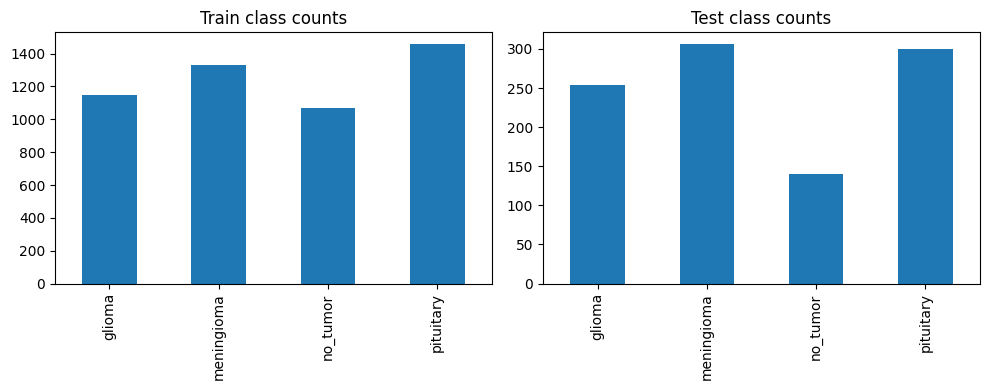


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LOG] After HOG shape: (5000, 8100)
[LOG] After PCA shape: (5000, 128)

=== Best Params ===
{
  "hog": {
    "orientations": 9,
    "pixels_per_cell": [
      8,
      8
    ],
    "cells_per_block": [
      2,
      2
    ]
  },
  "pca_n_components": 128,
  "rf": {
    "n_estimators": 600,
    "max_depth": 30,
    "max_features": "log2",
    "min_samples_split": 2,
    "min_samples_leaf": 1
  }
}


[LOG] After HOG shape: (1000, 8100)
[LOG] After PCA shape: (1000, 128)

=== Metrics ===
Accuracy:           0.915
Balanced Accuracy:  0.9223293595653485
F1 Macro:           0.9219068206172694

=== Classification Report ===
              precision    recall  f1-score   support

      glioma       0.92      0.83      0.87       254
  meningioma       0.86      0.88      0.87       306
    no_tumor       0.97      0.99      0.98       140
   pituitary       0.94      0.99      0.96       300

    accuracy                           0

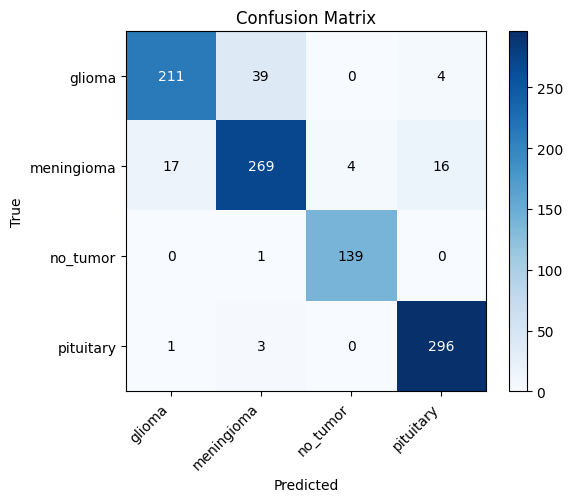


Done.


In [ ]:
X_train, X_test, y_train, y_test = load_data()
STATE["X_train"], STATE["X_test"], STATE["y_train"], STATE["y_test"] = X_train, X_test, y_train, y_test

describe_data(y_train, y_test)

best_model, best_params = hpo(X_train, y_train)
STATE["pipeline"], STATE["best_params"] = best_model, best_params

evaluate(best_model, X_test, y_test)

print("Done.")